# Find pools in City of Redlands

In [1]:
import os
from arcgis.gis import GIS
from arcgis.geocoding import geocode

gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOSPWD'))

# Inputs

In [2]:
extent = geocode('City of Redlands, CA', out_sr=3857)[0]['extent']
extent

{'xmin': -13052832.571464855,
 'ymin': 4026436.3359408537,
 'xmax': -13036579.925809037,
 'ymax': 4046053.3775858423}

<Item title:"Redlands Zoning" type:Feature Layer Collection owner:data.locadv>
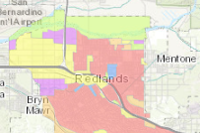

In [3]:
zoning_lyr = gis.content.get('d83b7a006f444212ac81a16399a37ac6') # Redlands Zoning 
zoning_lyr

<Item title:"USA NAIP Imagery: Color Infrared" type:Imagery Layer owner:esri>
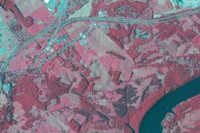

In [5]:
naip = gis.content.get('e4da3b6720f545aeaaf3fe8141da1e21') # USA NAIP Imagery: Color Infrared
naip

# Deploy trained model

### Load model

In [6]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

from util import load_model, norm, denorm, export_img, get_tile_images, get_img, \
        get_cropped_tiles, predict_, detect_objects, suppress_close_pools, overlap, predict_classf
from model import ConvnetBuilder, SSD_MultiHead, resnet34, k

torch.backends.cudnn.benchmark=True

f_model = resnet34
pretrained = '9.h5'

In [7]:
head_reg = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg)
model = models.model
model = load_model(model, pretrained)
model.eval()

path = r'inferencing/'

In [ ]:
!mkdir $path

In [6]:
import os
import math
import pandas as pd

from arcgis.raster.functions import apply
from arcgis.features import SpatialDataFrame
from arcgis.mapping import MapImageLayer
from arcgis.geometry import Envelope, project
from IPython.display import display

ext = Envelope(extent)
city_ext = project([ext], 3857, 3857)[0]

In [7]:
naiplayer = naip.layers[0]
naipfalse = apply(naiplayer, 'FalseColorComposite')

In [8]:
df = SpatialDataFrame.from_layer(zoning_lyr.layers[0])
residential_areas = list(df[df.Zoning=='Residential']['SHAPE'].extent)

areas = [Envelope({"xmin": x[0], "ymin": x[1], "xmax": x[2], "ymax": x[3], "spatialReference": 3857}) for x in residential_areas]

In [9]:
sz = 224
pixx, pixy = 90, 90
N = 16
w = h = N*pixx - pixx/2

nX = math.ceil((city_ext['xmax'] - city_ext['xmin'])/w)
nY = math.ceil((city_ext['ymax'] - city_ext['ymin'])/h)

years      = [2014, 2016]
objects    = []
inferenced = []
done_imgs  = {}

borders = [ (45,   45,   45,   45),   # xmin, ymin, xmax, ymax - map space
          (22.5, 22.5, 67.5, 67.5),   # bottom left corner
          (22.5, 67.5, 67.5, 22.5),   # top left corner
          (67.5, 22.5, 22.5, 67.5),   # bottom right corner
          (67.5, 67.5, 22.5, 22.5) ]  # top right corner

crops   = [ (112, 112, 112, 112),  # left, top, right, bottom -> xmin, ymax, xmax, ymin
            ( 56, 168, 168,  56),  # bottom left corner
            ( 56,  56, 168, 168),  # top left corner
            (168, 168,  56,  56),  # bottom right corner
            (168,  56,  56, 168) ] # top right corner

### Detect swimming pools

In [ ]:
for year in years:
    for i in range(nX):
        for j in range(nY):
            filename = f'redlands_large_{i}_{j}_({year}).jpg'

            xmin = city_ext['xmin'] + (j)*w
            ymin = city_ext['ymax'] - (i+1)*h
            xmax = xmin + N*pixx
            ymax = ymin + N*pixy

            ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}
            thisarea = Envelope(ext)

            for area in areas:
                if (overlap(area, ext)):
                    print(filename, 'Detecting...')

                    imgpath = path + filename

                    if not os.path.isfile(imgpath):
                        print(filename, 'Downloading...')
                        imgpath = naipfalse.export_image(ext, image_sr={'wkid': 3857}, 
                                         bbox_sr=3857, size=[224*8, 224*8], f='image', 
                                         export_format='jpg', adjust_aspect_ratio=False,
                                         mosaic_rule={"mosaicMethod": "esriMosaicAttribute", 
                                                "where": f'Year = {year}', 
                                                "sortField":"Year", 
                                                "sortValue":"3000", 
                                                "ascending":True, 
                                                "mosaicOperation":"MT_FIRST"},
                              save_folder=path,
                              save_file=filename)
                    
                    if filename not in inferenced:                        
                        img = np.array(Image.open(imgpath))

                        tiles = get_tile_images(img)
                        pools = detect_objects(model, tiles, ext, cycle=0)
                        print(filename, 'Found ' + str(len(pools)) + ' pools (pass #0)')
                        objects.extend(pools)

                        for iii, crop in enumerate(crops):
                            paddedtiles = get_cropped_tiles(img, crop)
                            pools = detect_objects(model, paddedtiles, ext, crop=borders[iii], cycle=iii+1)
                            print(filename, 'Found ' + str(len(pools)) + f' pools (pass #{iii+1})')
                            objects.extend(pools)

                        inferenced.append(filename)

# Post processing

### Create feature layers

In [15]:
import pickle 
pickle.dump(objects, open(path + 'objects.pkl', 'wb'))

In [10]:
import pickle
objects = pickle.load(open(path + 'objects.pkl', 'rb'))

In [11]:
len(objects)

34721

In [12]:
for i, obj in enumerate(objects):
    obj['SHAPE'] = {'x': obj['x'], 'y': obj['y']}

sdf = SpatialDataFrame.from_dict(objects)
sdf = sdf.reset_index()
sdf.sr = {'wkid': 3857}

In [13]:
selected, suppressed = suppress_close_pools(sdf, 15)

In [14]:
selected.to_featureclass(r'inferencing', 'selected_pools.shp')

'inferencing/selected_pools.shp'

In [15]:
selected.to_featureclass(r'inferencing', 'suppressed_pools.shp')

'inferencing/suppressed_pools.shp'

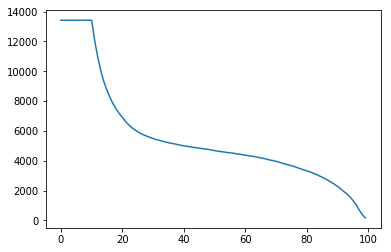

In [18]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.plot([len(selected[selected.score > i]) for i in np.arange(0, 100)]);

In [19]:
print('No. of pools detected: ', len(selected[selected.score > 30]))

No. of pools detected:  5486


In [20]:
gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOPWD'))

In [21]:
pools = gis.content.import_data(selected, title='Pools in Redlands', tags='deeplearning')    
pools

<Item title:"Pools in Redlands" type:Feature Layer Collection owner:demos_deldev>

In [23]:
aoi_parcels = parcels.layers[0]
# pools = gis.content.get('6531c1e0d3234bb8a7c630302060a7c3')

In [2]:
from arcgis.mapping.renderer import generate_renderer

parcels = gis.content.get('fd0ab9419c234a4783da3466e804ce85')
parcels_with_unauthorized_pools = gis.content.get('d02e7a19fdeb46c5ace518535c0c9646')
detected_pools = gis.content.get('dae7b7c72e0c41f88852597ec517fca1')

def show_results(rm):
    red_renderer = generate_renderer('Polygon', symbol_type='simple', symbol_style='s',
                                     colors=[[0,0,0,0]], outline_color=[255,0,0,255], line_width=2.25)
    rm.add_layer(parcels, {"renderer":{"type":"uniqueValue","field1":"pool_","defaultSymbol":{"color":None,"outline":{"color":[153,153,153,255],"width":0.75,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"defaultLabel":"Other","uniqueValueInfos":[{"value":"UNH","symbol":{"color":None,"outline":{"color":[0,255,255,255],"width":1.125,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"label":"UNH"},{"value":"HEA","symbol":{"color":None,"outline":{"color":[0,255,255,255],"width":1.125,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"label":"HEA"}]}})
    rm.add_layer(parcels_with_unauthorized_pools, {'renderer': red_renderer})
    #result_map.add_layer(detected_pools, {'renderer': { "type": "uniqueValue", "field1": None,"valueExpression": "if (($feature.pool_ == 'UNH') || ($feature.pool_ == 'HEA')) {\n    return \"Authorized Pool\";\n} else if ($feature.score > 75) {\n    return \"Unauthorized Pool (high confidence)\";\n} else  if ($feature.score > 60) {\n    return \"Unauthorized Pool (low confidence)\";\n}","valueExpressionTitle": "Custom","uniqueValueInfos": [{"value":"Authorized Pool","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowYellowCenter.png","width":31.5,"height":31.5},"label":"Authorized Pool"},{"value":"Unauthorized Pool (high confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowRedCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (high confidence)"},{"value":"Unauthorized Pool (low confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowOrangeCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (low confidence)"}]}})
    
arcade_renderer = {'renderer': { "type": "uniqueValue", "field1": None,"valueExpression": "if (($feature.pool_ == 'UNH') || ($feature.pool_ == 'HEA')) {\n    return \"Authorized Pool\";\n} else if ($feature.score > 75) {\n    return \"Unauthorized Pool (high confidence)\";\n} else  if ($feature.score > 60) {\n    return \"Unauthorized Pool (low confidence)\";\n}","valueExpressionTitle": "Custom","uniqueValueInfos": [{"value":"Authorized Pool","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowYellowCenter.png","width":31.5,"height":31.5},"label":"Authorized Pool"},{"value":"Unauthorized Pool (high confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowRedCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (high confidence)"},{"value":"Unauthorized Pool (low confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowOrangeCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (low confidence)"}]}}
   

### Analysis: Join pools to residential parcels

<Item title:"Parcels_In_Redlands" type:Feature Layer Collection owner:demos_deldev>
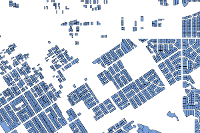

In [22]:
parcels = gis.content.get('fd0ab9419c234a4783da3466e804ce85') # Parcels_In_Redlands 
parcels

In [24]:
from arcgis.features.summarize_data import join_features

pools_within_parcels = join_features(pools, aoi_parcels,
                                           join_operation='JoinOneToMany',
                                           spatial_relationship='intersects',
                                           output_name="Pools_Within_Parcels")
pools_within_parcels

<Item title:"Pools_Within_Parcels" type:Feature Layer Collection owner:demos_deldev>

#### Find pool with highest score in parcel

In [25]:
df = pools_within_parcels.layers[0].query().df
df.to_featureclass(r'inferencing', 'Pools_Within_Parcels.shp')

'inferencing/Pools_Within_Parcels.shp'

In [33]:
df = SpatialDataFrame.from_featureclass('inferencing/Pools_Within_Parcels.shp')

In [26]:
grouped = (df[(df['score'] > 30) & (df['c_score'] > 50.0)].groupby(by='apn').apply(lambda x: x.loc[x.c_score.idxmax(), :]))
grouped.reset_index(drop=True, inplace=True)

temp = SpatialDataFrame(data=grouped)
SHAPE = temp['SHAPE'].copy()
del temp['SHAPE']
temp = temp.set_geometry(SHAPE)
temp.sr = {'wkid': 3857}

detected_pools = gis.content.import_data(temp, title='Detected Swimming Pools', tags='deeplearning')    
detected_pools

<Item title:"Detected Swimming Pools" type:Feature Layer Collection owner:demos_deldev>

In [9]:
unauthorized_pools = detected_pools.layers[0]
unauthorized_pools.filter = "(pool_ <> 'HEA') AND (pool_ <> 'UNH') AND (score > 60)"

### Analysis: Find parcels with unassessed swimming pools

<Item title:"Parcels_With_Unassessed_Pools" type:Feature Layer Collection owner:demos_deldev>
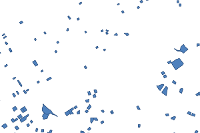

In [28]:
parcels_with_unassessed_pools = join_features(aoi_parcels, unassessed_pools, 
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="Parcels_With_Unassessed_Pools")
parcels_with_unassessed_pools

### Create web map

In [35]:
result_map = gis.map('Redlands County Club, Redlands, CA', zoomlevel=17)
result_map.basemap = 'satellite'
result_map

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [36]:
show_results(result_map)

In [81]:
webmap_item = result_map.save({
    'title': 'Detected swimming pools',
    'tags': 'deeplearning',
    'snippet': 'Swimming pools detected using deep learning'
})
webmap_item

<Item title:"Detected swimming pools" type:Web Map owner:demos_deldev>

# Generate Report

In [29]:
parcel_df = parcels_with_unassessed_pools.layers[0].query().df

In [32]:
parcel_df[['apn', 'pool_', 'spa_', 'taxstatus', 'landvalue', 'improvemen']] 

,apn,pool_,spa_,taxstatus,landvalue,improvemen
0,017304123,,,ASSESSED BY COUNTY,"5,027","12,116"
1,017021117,,,ASSESSED BY COUNTY,"51,377","154,129"
2,017319122,,,ASSESSED BY COUNTY,"113,178","237,673"
3,016731330,,,ASSESSED BY COUNTY,"57,800","136,300"
4,016731303,,,ASSESSED BY COUNTY,"50,050","116,784"
5,016731301,,,ASSESSED BY COUNTY,"22,476","76,242"
6,017221219,,,ASSESSED BY COUNTY,"30,027","117,537"
7,017328110,,,ASSESSED BY COUNTY,"54,114","162,340"
8,017301231,,,ASSESSED BY COUNTY,"55,479","149,794"
9,121205167,,,ASSESSED BY COUNTY,"139,800","327,000"


## Looking in closer

In [40]:
m = gis.map('1418 Sterling Rd, Redlands, CA')
m.basemap = 'satellite'
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [41]:
show_results(m)
m.add_layer(detected_pools, arcade_renderer)

# Zombie pools

## Classify pools as 'clean' or 'green' using deep learning

In [97]:
folder = 'inferencing/cleangreen_2706'

<Item title:"World Imagery" type:Map Image Layer owner:esri>
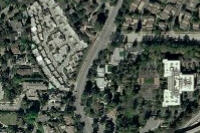

In [149]:
imagery = gis.content.get('10df2279f9684e4a9f6a7f08febac2a9')
imagery

In [150]:
imagery_lyr = MapImageLayer.fromitem(imagery)

In [ ]:
for index, row in df.iterrows():
    img_name = 'img' + str(df.loc[index,'parcelnumb']).zfill(4)# index).zfill(4)
    try:
        g = row['SHAPE']
        x, y = g['x'] - 7, g['y'] - 7
        ext = (x, y, x + 14, y + 14)
        if not os.path.isfile(folder + '/' + img_name + '.jpg'):
            imagery_lyr.export_map(ext, 102100, '224,224', f='image', format='jpg',
                    save_folder=folder, save_file='{}.jpg'.format(img_name))
            print(f'{img_name} downloaded..')    
    except Exception as e:
        print('Error {} getting {}'.format(e,img_name))

### Load model for classifying zombie pools

In [82]:
model_path = 'clean_green.h5'

In [83]:
models = ConvnetBuilder(resnet34, 2, False, False, pretrained=True)
clean_green_model = models.model
clean_green_model = load_model(clean_green_model, model_path)

In [84]:
clean_green_model.eval();

In [ ]:
cleangreen_scores = {}

for index, row in df.iterrows():
    
    try:
        img_name = 'img' + str(index).zfill(4) + '.jpg'
        img_path = folder + '/' + img_name
        img = np.array(Image.open(img_path))
        score = float(predict_classf(clean_green_model,
                               norm(img).transpose(2, 0, 1))[0])
        print(img_name, score)
        cleangreen_scores[index] = score
        
    except Exception as e:
        cleangreen_scores[index] = -1
        print(img_name, '-1')

In [86]:
df['neglected'] = pd.Series(list(cleangreen_scores.values())) * 100.0

In [89]:
df

,index,SHAPE,acreage,assessclas,assessdesc,baseyear,c_count,c_score,category,cycle,...,score,shape__are,shape__len,taxrateare,taxstatus,x,y,zoning,zoningdesc,neglected
0,0,"{'x': -13043526.5698, 'y': 4031292.8621999994}",0.66,SINGLE FAMILY RESIDENTIAL,SFR,1999,5,377.741498,pool,0,...,69.139081,3997.628906,257.352438,0005000,ASSESSED BY COUNTY,-1.304353e+07,4.031293e+06,CITY OF REDLANDS,City of Redlands,2.218449e-05
1,1,"{'x': -13037541.5934, 'y': 4032106.3464}",0.47,SINGLE FAMILY RESIDENTIAL,SFR,1977,2,141.366059,pool,0,...,69.117135,3031.128906,274.643731,0005041,ASSESSED BY COUNTY,-1.303754e+07,4.032106e+06,CITY OF REDLANDS,City of Redlands,-1.000000e+02
2,2,"{'x': -13041278.242899999, 'y': 4035130.914700...",0.20,SINGLE FAMILY RESIDENTIAL,SFR,2013,4,244.807062,pool,3,...,69.111711,1172.414062,139.553292,0005000,ASSESSED BY COUNTY,-1.304128e+07,4.035131e+06,CITY OF REDLANDS,City of Redlands,1.501394e-07
3,3,"{'x': -13042867.6335, 'y': 4033602.322300002}",0.34,SINGLE FAMILY RESIDENTIAL,SFR,2011,2,137.177393,pool,2,...,69.082594,2011.394531,185.466477,0005000,ASSESSED BY COUNTY,-1.304287e+07,4.033602e+06,CITY OF REDLANDS,City of Redlands,6.998866e-04
4,4,"{'x': -13044567.4123, 'y': 4034944.909599997}",0.28,SINGLE FAMILY RESIDENTIAL,SFR,2014,3,224.423397,pool,1,...,69.063663,1707.015625,199.618934,0005000,ASSESSED BY COUNTY,-1.304457e+07,4.034945e+06,CITY OF REDLANDS,City of Redlands,3.947612e-07
5,5,"{'x': -13044156.569699999, 'y': 4035199.444899...",0.24,SINGLE FAMILY RESIDENTIAL,SFR,2009,3,256.319761,pool,4,...,69.030374,1435.558594,164.913617,0005000,ASSESSED BY COUNTY,-1.304416e+07,4.035199e+06,CITY OF REDLANDS,City of Redlands,5.994645e-06
6,6,"{'x': -13044282.6254, 'y': 4034475.0693999976}",0.22,SINGLE FAMILY RESIDENTIAL,SFR,2009,4,352.502984,pool,4,...,69.004261,1265.789062,159.689090,0005000,ASSESSED BY COUNTY,-1.304428e+07,4.034475e+06,CITY OF REDLANDS,City of Redlands,7.355307e-06
7,7,"{'x': -13045697.0187, 'y': 4034713.321999997}",0.18,SINGLE FAMILY RESIDENTIAL,SFR,1994,3,190.294049,pool,0,...,68.923742,1091.968750,133.288548,0005000,ASSESSED BY COUNTY,-1.304570e+07,4.034713e+06,CITY OF REDLANDS,City of Redlands,4.059679e+01
8,8,"{'x': -13039499.069699999, 'y': 4031657.728900...",0.57,SINGLE FAMILY RESIDENTIAL,SFR,2014,5,336.370108,pool,2,...,68.885207,3144.562500,228.057868,0005011,ASSESSED BY COUNTY,-1.303950e+07,4.031658e+06,CITY OF REDLANDS,City of Redlands,1.879729e-03
9,9,"{'x': -13045754.1072, 'y': 4033047.2283999994}",2.40,SINGLE FAMILY RESIDENTIAL,SFR,1998,3,157.480524,pool,4,...,68.854231,14731.480469,558.731145,0005000,ASSESSED BY COUNTY,-1.304575e+07,4.033047e+06,CITY OF REDLANDS,City of Redlands,1.438463e-03


In [87]:
df.sr = {'wkid': 3857}

### Create layer of pools needing inspection

In [88]:
zombiepools_lyr = portal.content.import_data(df, title='Pools_needing_maintenance_in_Redlands (27 Jun 2018-a)', tags='datascience')    
zombiepools_lyr

<Item title:"Pools_needing_maintenance_in_Redlands (27 Jun 2018-a)" type:Feature Layer Collection owner:arcgis_python>

In [59]:
inspection_pools = df[(df.neglected > 76.5) & (df.score > 45)]

In [60]:
inspection_lyr = portal.content.import_data(inspection_pools, title='Pools_needing_inspection (27 Jun 2018-a)', tags='datascience')    
inspection_lyr

<Item title:"Pools_needing_inspection" type:Feature Layer Collection owner:arcgis_python>

## Create layer of pools needing inspection

In [64]:
from arcgis.features.summarize_data import join_features

parcels_needing_inspection = join_features(aoi_parcels, inspection_lyr,
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="Parcels_needing_inspection")
parcels_needing_inspection

<Item title:"Parcels_needing_inspection" type:Feature Layer Collection owner:arcgis_python>

# Imagery Visit app to inspect results

In [49]:
from IPython.display import IFrame
IFrame('http://maps.arcgis.com/apps/ImageVisit/index.html?appid=5502f61d9d944cd2900021970682bfed', width=900, height=500)

# Create assignments for Workforce for ArcGIS

In [30]:
pools_layer = gis.content.get("571f435be7dc43b3aaf24aabec96070a").layers[0]

# get the pools that require inspections
pools = pools_layer.query("score > 70.7 AND c_score > 200")

In [ ]:
# The Workforce project
project = Project(gis.content.get("9ee1b2a4cb884ecaaa7ef350a77db04d"))
# The first/only dispatcher (demo_deldev)
dispatcher = project.dispatchers.get(1)
# The assignment type
pool_inspection = project.assignment_types.get(name="Pool Inspection")

# list of assignments to add
assignments = []
for pool in pools:
    
    # Set priority based on neglected field (default to "none")
    priority = "none"
    if pool.attributes["neglected"] >= 90:
        priority = "critical"
    elif pool.attributes["neglected"] >= 80:
        priority = "high"
    elif pool.attributes["neglected"] >= 70:
        priority = "medium"
    elif pool.attributes["neglected"] >= 60:
        priority = "low"
    
    # Create the assignment objects to add
    assignments.append(
        Assignment(
            project,
            geometry=pool.geometry,
            location=pool.attributes["ownername"], # This is a string that represent the location/address
            status="unassigned",
            description="Pool Inspection Required", # Any description (could build a string based on other fields)
            assignment_type=pool_inspection,
            dispatcher=dispatcher,
            priority=priority,
            due_date=datetime.now()+timedelta(days=2) # This attribute is not required and can be omitted if desired
        )
    )
    
# Add the all of the assignments
assignments = project.assignments.batch_add(assignments)